<a href="https://colab.research.google.com/github/goyetc/CNNs_Columbia/blob/master/ADL_HW2_CG2970.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1 - Train a model on an existing data set
### Much of this code is from the provided notebook, 4.3-transfer-learning.ipynb

* The general structure of this notebook, as can be seen in the outline, is as follows:
>* Part 1 - Q1 - using a pretrained model on the mini flowers dataset using transfer learning
>* Part 1 - Q2 - evaluating performance of an alternate pre-trained model
>* Part 2 - Q1 - Columbia Landmark data collection and prep for multi-class classification
>* Part 2 - Q2 - Evaluating performance of Columbia Landmark classifier using transfer learning
>* Part 2 - Q3 - Evaluating performance of an alternate pre-loaded model on landmark classification task -- chose MobileNet V2 due to small model size compared to VGG16 and Xception

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os

# The code in this notebook should work identically in TF v1 and v2
import tensorflow as tf
import zipfile

from tensorflow.keras.applications import VGG16

from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
import random

In [0]:
from tensorflow.keras.applications import Xception
#keras.applications.xception.Xception(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)


In [0]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Part 1 - Q1 - Using a pretrained model: Xception
* Existing code modified
* Download the dataset
* Set up directories
* Note that this has been modified for five classes. 
* This was a time consuming process, which could surely be automated.. I have yet to experiment with the 'flow from dataframe' technique

In [0]:
local_zip = '/content/drive/My Drive/mini_flowers.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/mini_flowers')
zip_ref.close()

In [0]:
base_dir = '/tmp/mini_flowers'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

train_daisy_dir = os.path.join(train_dir, 'daisy')
train_dandelion_dir = os.path.join(train_dir, 'dandelion')
train_roses_dir = os.path.join(train_dir, 'roses')
train_sunflowers_dir = os.path.join(train_dir, 'sunflowers')
train_tulips_dir = os.path.join(train_dir, 'tulips')

validation_daisy_dir = os.path.join(validation_dir, 'daisy')
validation_dandelion_dir = os.path.join(validation_dir, 'dandelion')
validation_roses_dir = os.path.join(validation_dir, 'roses')
validation_sunflowers_dir = os.path.join(validation_dir, 'sunflowers')
validation_tulips_dir = os.path.join(validation_dir, 'tulips')

In [0]:
#num_cats_tr = len(os.listdir(train_cats_dir))
#num_dogs_tr = len(os.listdir(train_dogs_dir))
n_daisy_tr = len (os.listdir(train_daisy_dir))
n_dandelion_tr = len(os.listdir(train_dandelion_dir))
n_roses_tr = len(os.listdir(train_roses_dir))
n_sunflowers_tr = len(os.listdir(train_sunflowers_dir))
n_tulips_tr = len(os.listdir(train_tulips_dir))

#num_cats_val = len(os.listdir(validation_cats_dir))
#num_dogs_val = len(os.listdir(validation_dogs_dir))
n_daisy_val = len(os.listdir(validation_daisy_dir))
n_dandelion_val = len(os.listdir(validation_dandelion_dir))
n_roses_val = len(os.listdir(validation_roses_dir))
n_sunflowers_val = len(os.listdir(validation_sunflowers_dir))
n_tulips_val = len(os.listdir(validation_tulips_dir))

total_train = n_daisy_tr + n_dandelion_tr + n_roses_tr + n_sunflowers_tr + n_tulips_tr
total_val = n_daisy_val+ n_dandelion_val + n_roses_val + n_sunflowers_val + n_tulips_val

In [0]:
print('Training daisy images:', n_daisy_tr)
print('Training tulips images:', n_tulips_tr)
print('Training dandelion images:', n_dandelion_tr)
print('Training roses images:', n_roses_tr)
print('Training sunflowers images:', n_sunflowers_tr)

print('Validation daisy images:', n_daisy_val)
print('Validation tulip images:', n_tulips_val)

print("--")

print("Total training images:", total_train)
print("Total validation images:", total_val)

Training daisy images: 200
Training tulips images: 200
Training dandelion images: 200
Training roses images: 200
Training sunflowers images: 200
Validation daisy images: 100
Validation tulip images: 100
--
Total training images: 1000
Total validation images: 500


#### Instantiating the model: Xception
* I chose to use the Xception model- the authors claim it outperforms Inception V3, and is hence useful for transfer learning in computer vision applications. 
* It's worth noting that Xception has nearly 21 million paramaters, to VGG16's paltry 14.7. Perhaps this will be a foolish choice for training purposes, but I am bold. 
* Notice we do not include the `top` nAKA the Dense layers used to classify the 1,000 classes from ImageNet.

In [0]:
conv_base_Xc = Xception(include_top=False, weights='imagenet', input_shape=(150,150, 3))


Instructions for updating:
Colocations handled automatically by placer.
83689472/83683744 [==============================] - 7s 0us/step


In [0]:
conv_base_Xc.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

##### It's worth noting that Xception has nearly 21 million paramaters, to VGG16's paltry 14.7. Perhaps this will be a foolish choice for training purposes, but I am bold. 

#### Two approaches leveraged with Xception transfer learning(excerpt from original notebook follows)

* We will at tempt methods 1 & 2 to observe impact of data augmentation
* This requires two different approaches to transfer learning
* We will use these two approaches in part 2 of the homework as well

---- 

At this point, there are two ways we could proceed:

1. Efficiently, with a caching trick. We will forward each image from our training set through VGG once, extract the activations, and cache them to memory. Later, we will use these activations as input to a Dense layer we will train to classify our data. This is efficient, since it requires forwarding the images through the convolutional base only once (this is the most expensive part of our pipeline). The downside is this prevents us from using data augmentation (which causes every image to be unqiue, preventing caching).

2. Alternatively, we could extend the VGG model by adding one or more Dense layers on top of the pretrained base. We could then run the entire model on our input data. This allows us to use data augmentation (and simplifies our code!), but this technique is quite slow by comparison (since every image we generate is unique, it will have to run through the conv_base).

We will demonstrate both techniques, starting with the first.

In [0]:
TARGET_SHAPE = 150 

#batch size altered to be factor of sample size
BATCH_SIZE = 20

In [0]:
# Cache activations for our training and validation data
datagen = ImageDataGenerator(rescale=1./255)

def extract_features(directory, sample_count):
  
  #note, this line was modified to fit dense layer in Xception
    features = np.zeros(shape=(sample_count, 5, 5, 2048))
    labels = np.zeros(shape=(sample_count,5))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(TARGET_SHAPE, TARGET_SHAPE),
        batch_size=BATCH_SIZE,
        #changed for problem at hand
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
      
        features_batch = conv_base_Xc.predict(inputs_batch)
        # print(features_batch.shape)
        # (32, 4, 4, 512)
        # Think: batch_size, rows, cols, channels
        
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features_Xc, train_labels_Xc = extract_features(train_dir, 1000)
validation_features_Xc, validation_labels_Xc = extract_features(validation_dir, 500)

Found 1000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


The features we've extracted from VGG are of shape (batch_size, 4, 4, 512) -- think, rows, cols, channels. We will feed these to a Dense layer, so we must flatten (or unroll) them first.

---



#### The features are now shape (20, 5, 5, 2048), which match Xception's dense layer

In [0]:
train_features_Xc.shape

(1000, 5, 5, 2048)

In [0]:
FLATTENED_SHAPE = 5 * 5 * 2048

train_features_Xc = np.reshape(train_features_Xc, (1000, FLATTENED_SHAPE))
validation_features_Xc = np.reshape(validation_features_Xc, (500, FLATTENED_SHAPE))

Now, we can define a simple model, and train it using the features we just extracted from VGG16. This model should train quickly (we're only learning weights for the Dense layers).

In [0]:
EPOCHS = 50

### Xception caching run

* Note: Previously ran with 100 epochs.. overfitting noticed almost immediately

In [0]:
model_Xc = Sequential()
model_Xc.add(Dense(256, activation='relu', input_dim=FLATTENED_SHAPE))
model_Xc.add(Dropout(0.5))
#output layer dim = 5
model_Xc.add(Dense(5, activation='softmax'))
#softmax used instead of sigmoid for multiclass, single-label classification, per ch 4.1 pp 114

model_Xc.compile(optimizer='adam',
              #altered for multi-class
              loss='categorical_crossentropy',
              metrics=['acc'])

history_Xception = model_Xc.fit(train_features_Xc, train_labels_Xc,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(validation_features_Xc, validation_labels_Xc))

Train on 1000 samples, validate on 500 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 9.4984 - acc: 0.3730 - val_loss: 7.8426 - val_acc: 0.4840
Epoch 2/50
1000/1000 [==============================] - 1s 1ms/sample - loss: 7.7561 - acc: 0.4900 - val_loss: 6.6703 - val_acc: 0.5720
Epoch 3/50
1000/1000 [==============================] - 1s 1ms/sample - loss: 6.5270 - acc: 0.5700 - val_loss: 5.7607 - val_acc: 0.6140
Epoch 4/50
1000/1000 [==============================] - 1s 1ms/sample - loss: 4.6703 - acc: 0.6780 - val_loss: 5.9068 - val_acc: 0.6160
Epoch 5/50
1000/1000 [==============================] - 1s 1ms/sample - loss: 5.0112 - acc: 0.6680 - val_loss: 3.9665 - val_acc: 0.7420
Epoch 6/50
1000/1000 [==============================] - 1s 1ms/sample - loss: 4.3840 - acc: 0.7030 - val_loss: 5.4614 - val_acc: 0.6340
Epoch 7/50
1000/1000 [==============================] - 1s 1ms/sample - loss: 3.6819 - ac

#### Accuracy, Loss plots for Xception, cache trick


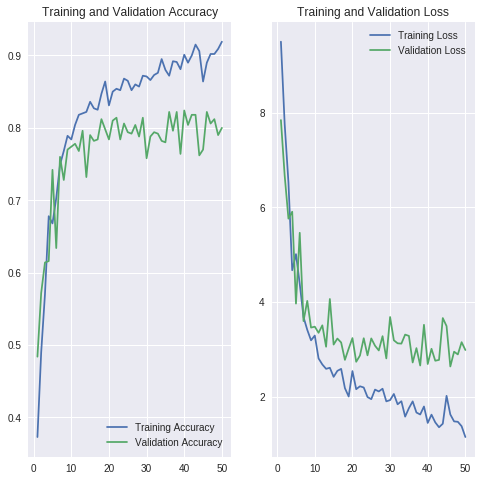

In [0]:
acc = history_Xception.history['acc']
val_acc = history_Xception.history['val_acc']

loss = history_Xception.history['loss']
val_loss = history_Xception.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Average of final 10 validation accuracies for Xception w/caching trick

In [0]:
print(np.max(history_Xception.history['val_acc'][-40:]))

0.824


### Xception data augmentation with frozen base

Pretty cool, right? Already, our validation accuracy is above our previous notebook. Notice we're still overfitting almost immediately.  Now, let's employ the second approach, using data augmentation. First, let's build a new model by extending VGG. Because models behave just like layers, you can add a model (like our conv_base) to a Sequential model just like you would add a layer. So you can do the following:

In [0]:
model_Xc2 = Sequential()
model_Xc2.add(conv_base_Xc)
model_Xc2.add(Flatten())
model_Xc2.add(Dense(256, activation='relu'))
model_Xc2.add(Dense(5, activation='softmax'))

Here's how our model looks now.

In [0]:
model_Xc2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 1285      
Total params: 33,970,221
Trainable params: 33,915,693
Non-trainable params: 54,528
_________________________________________________________________


Before we train our model, we need to "freeze" the convolutional base (this prevents it from being updated during training).  Since the Dense layers we've added have their weights initialized randomly, they will make large errors initially, and the gradient in turn would be propagated backward through VGG (causing erroneously large updates to already useful weights)

In [0]:
conv_base_Xc.trainable = False

In [0]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=train_dir, 
    shuffle=True, 
    target_size=(TARGET_SHAPE,TARGET_SHAPE),
    class_mode='categorical')

# Validation data should not be augmented!
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=validation_dir, 
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode='categorical')

Found 1000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [0]:
EPOCHS_da = 50

Let's compile and train our model. This will be quite slow. Now would be a good time to get a cup of coffee.

In [0]:
model_Xc2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

# Now is a good time for a cup of coffee
history_Xc2 = model_Xc2.fit_generator(
      train_data_gen,
      steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
      epochs=EPOCHS_da,
      validation_data=val_data_gen,
      validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
      verbose=2)

Epoch 1/50
25/25 [==============================] - 4s 154ms/step - loss: 8.4233 - acc: 0.4400
 - 13s - loss: 8.6149 - acc: 0.3770 - val_loss: 8.4233 - val_acc: 0.4400
Epoch 2/50
25/25 [==============================] - 3s 117ms/step - loss: 6.9329 - acc: 0.4920
 - 11s - loss: 7.9184 - acc: 0.4420 - val_loss: 6.9329 - val_acc: 0.4920
Epoch 3/50
25/25 [==============================] - 3s 116ms/step - loss: 4.3371 - acc: 0.6500
 - 11s - loss: 6.2794 - acc: 0.5110 - val_loss: 4.3371 - val_acc: 0.6500
Epoch 4/50
25/25 [==============================] - 3s 117ms/step - loss: 4.2835 - acc: 0.6580
 - 11s - loss: 4.7672 - acc: 0.6150 - val_loss: 4.2835 - val_acc: 0.6580
Epoch 5/50
25/25 [==============================] - 3s 116ms/step - loss: 4.0539 - acc: 0.6200
 - 11s - loss: 4.3371 - acc: 0.6350 - val_loss: 4.0539 - val_acc: 0.6200
Epoch 6/50
25/25 [==============================] - 3s 117ms/step - loss: 0.8136 - acc: 0.7360
 - 11s - loss: 1.5332 - acc: 0.6520 - val_loss: 0.8136 - val_acc:

#### Xception: Results for data augmentation and training with frozen base

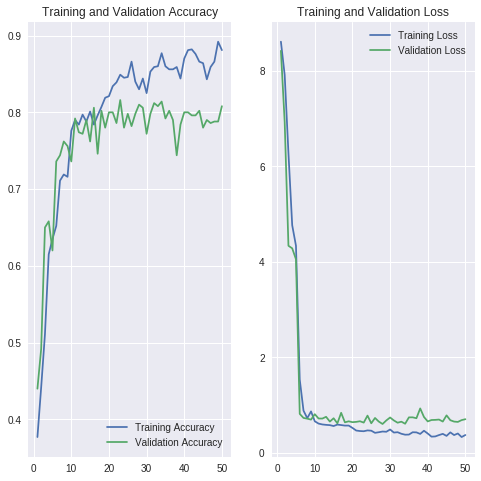

In [0]:
acc = history_Xc2.history['acc']
val_acc = history_Xc2.history['val_acc']

loss = history_Xc2.history['loss']
val_loss = history_Xc2.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
print(np.max(history_Xc2.history['val_acc'][-40:]))

0.816


*Interestingly enough.. no improvement demonstrated with data augmentation and frozen base*



## Part 1 - Q2 - Using a pretrained model: VGG16
* Comparison of VGG16 and Xception will follow below

In [0]:
# Notice we do not include the `top`, or the Dense layers used to classify the 1,000 classes from ImageNet.
#conv_base = VGG16(weights='imagenet',include_top=False, input_shape=(150, 150, 3))
conv_base_VGG = VGG16(include_top=False, weights='imagenet', input_shape=(150,150, 3))


58892288/58889256 [==============================] - 1s 0us/step


In [0]:
conv_base_VGG.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
TARGET_SHAPE = 150 

#batch size altered to be factor of sample size
BATCH_SIZE = 20

In [0]:
# Cache activations for our training and validation data
datagen = ImageDataGenerator(rescale=1./255)

def extract_features(directory, sample_count):
  
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count,5))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(TARGET_SHAPE, TARGET_SHAPE),
        batch_size=BATCH_SIZE,
        #changed for problem at hand
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
      
        features_batch = conv_base_VGG.predict(inputs_batch)
        #print(features_batch.shape)
        # (32, 4, 4, 512)
        # Think: batch_size, rows, cols, channels
        
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 1000)
validation_features, validation_labels = extract_features(validation_dir, 500)

Found 1000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


### The features are now shape (20, 4, 4, 512), which match VGG16's dense layer

In [0]:
train_features.shape

(1000, 4, 4, 512)

In [0]:
FLATTENED_SHAPE = 4 * 4 * 512

train_features = np.reshape(train_features, (1000, FLATTENED_SHAPE))
validation_features = np.reshape(validation_features, (500, FLATTENED_SHAPE))

Now, we can define a simple model, and train it using the features we just extracted from VGG16. This model should train quickly (we're only learning weights for the Dense layers).

In [0]:
EPOCHS = 50

### Note: VGG Caching Model Details

In [0]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=FLATTENED_SHAPE))
model.add(Dropout(0.5))
#output layer dim = 5
model.add(Dense(5, activation='softmax'))
#softmax used instead of sigmoid for multiclass, single-label classification, per ch 4.1 pp 114

model.compile(optimizer='adam',
              #altered for multi-class
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(validation_features, validation_labels))

Train on 1000 samples, validate on 500 samples
Epoch 1/50
1000/1000 [==============================] - 1s 894us/sample - loss: 1.4074 - acc: 0.4970 - val_loss: 0.8262 - val_acc: 0.6880
Epoch 2/50
1000/1000 [==============================] - 0s 431us/sample - loss: 0.7642 - acc: 0.7090 - val_loss: 0.7324 - val_acc: 0.7620
Epoch 3/50
1000/1000 [==============================] - 0s 424us/sample - loss: 0.5758 - acc: 0.7830 - val_loss: 0.6625 - val_acc: 0.7520
Epoch 4/50
1000/1000 [==============================] - 0s 434us/sample - loss: 0.4099 - acc: 0.8550 - val_loss: 0.5980 - val_acc: 0.7860
Epoch 5/50
1000/1000 [==============================] - 0s 428us/sample - loss: 0.3682 - acc: 0.8710 - val_loss: 0.7709 - val_acc: 0.7420
Epoch 6/50
1000/1000 [==============================] - 0s 430us/sample - loss: 0.2662 - acc: 0.9040 - val_loss: 0.5845 - val_acc: 0.7900
Epoch 7/50
1000/1000 [==============================] - 0s 434us/sample - loss: 0.2078 - acc: 0.9410 - val_loss: 0.6803 - val

#### Results for approach two, VGG16, caching

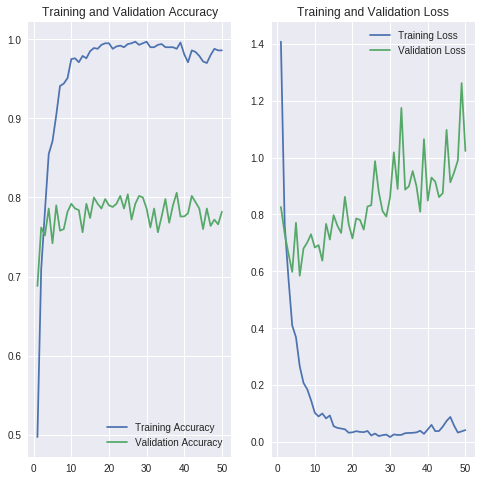

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
print(np.max(history.history['val_acc']))

0.806


#### Notes on VGG16 vs Xception, caching method
* Similar performance achieved (slightly lower)
* Much faster training time
* Note: equivalent node size in dense layer used, 256. No significant difference noted in performance with 512 

### VGG2 w/data augmentation & base model

In [0]:
model_VGG2 = Sequential()
model_VGG2.add(conv_base_VGG)
model_VGG2.add(Flatten())
model_VGG2.add(Dense(256, activation='relu'))
model_VGG2.add(Dense(3, activation='softmax'))

Here's how our model looks now.

In [0]:
model_VGG2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 771       
Total params: 16,812,867
Trainable params: 16,812,867
Non-trainable params: 0
_________________________________________________________________


Before we train our model, we need to "freeze" the convolutional base (this prevents it from being updated during training).  Since the Dense layers we've added have their weights initialized randomly, they will make large errors initially, and the gradient in turn would be propagated backward through VGG (causing erroneously large updates to already useful weights)

In [0]:
conv_base_VGG.trainable = False

In [0]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=train_dir, 
    shuffle=True, 
    target_size=(TARGET_SHAPE,TARGET_SHAPE),
    class_mode='categorical')

# Validation data should not be augmented!
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=validation_dir, 
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode='categorical')

Found 1000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [0]:
EPOCHS_da = 50

Let's compile and train our model. This will be quite slow. Now would be a good time to get a cup of coffee.

In [0]:
model_VGG2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

# Now is a good time for a cup of coffee
history_VGG2 = model_VGG2.fit_generator(
      train_data_gen,
      steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
      epochs=EPOCHS_da,
      validation_data=val_data_gen,
      validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
      verbose=2)

Epoch 1/50
25/25 [==============================] - 4s 149ms/step - loss: 0.8630 - acc: 0.6820
 - 12s - loss: 1.1779 - acc: 0.5720 - val_loss: 0.8630 - val_acc: 0.6820
Epoch 2/50
25/25 [==============================] - 3s 132ms/step - loss: 0.7955 - acc: 0.7240
 - 11s - loss: 0.7937 - acc: 0.6910 - val_loss: 0.7955 - val_acc: 0.7240
Epoch 3/50
25/25 [==============================] - 3s 132ms/step - loss: 0.7192 - acc: 0.7560
 - 11s - loss: 0.6787 - acc: 0.7440 - val_loss: 0.7192 - val_acc: 0.7560
Epoch 4/50
25/25 [==============================] - 3s 132ms/step - loss: 0.7043 - acc: 0.7720
 - 11s - loss: 0.6504 - acc: 0.7500 - val_loss: 0.7043 - val_acc: 0.7720
Epoch 5/50
25/25 [==============================] - 3s 132ms/step - loss: 0.6417 - acc: 0.7860
 - 11s - loss: 0.5412 - acc: 0.8090 - val_loss: 0.6417 - val_acc: 0.7860
Epoch 6/50
25/25 [==============================] - 3s 132ms/step - loss: 0.8476 - acc: 0.7120
 - 11s - loss: 0.5255 - acc: 0.7940 - val_loss: 0.8476 - val_acc:

#### VGG2 data aug results

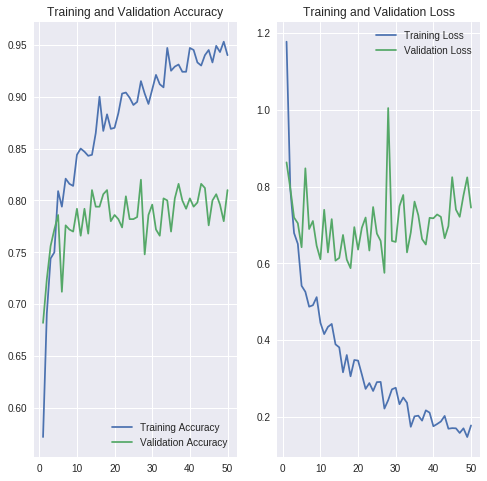

In [0]:
acc = history_VGG2.history['acc']
val_acc = history_VGG2.history['val_acc']

loss = history_VGG2.history['loss']
val_loss = history_VGG2.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
print(np.max(history_VGG2.history['val_acc']))

0.82


#### Notes on VGG16 vs Xception, data augmentation
* Slight improvement to accuracy using data augmentation
>* VGG16 appears more amenable to data augmentation than Xception.. perhaps Xception is better at developing scale/translation/shift invariant concepts?
* Much faster training time than Xception
* Note: equivalent node size in dense layer used, 256. No significant difference noted in performance with 512 

# Part 2 : Columbia Landmarks

### Note: the following script is based on the provided notebook for transfer learning.
* I have built the approaches herein with best practices from chapter 5 of Deep Learning with Python, and what was learned in part 1 of this assignment (see bullet points on VGG16 vs Xception, at end of part 1)

## Part 2 - Q1 - Collect the data set (discussion and notes within)
* Three landmarks were chosen:
> * Daniel Chester French's *Alma Mater*, a gift from alumni Robert Goelet, class of 1860
> * Meadmore's *The Curl*, 1968
> * Gregory Wyatt's *Scholar's Lion*
* Some comments on the above choices and methodologies for taking the pictures
> * Burst mode on a Google Pixel 2 was used to capture many images. I attempted to get multiple different vantage points for each sculpture, including location in orientation to the sculpture, as well as different heights, when possible. Some people taking a tour of campus may have found my behavior very strange *shrug*
> * Images were captured in two separate batches for all three landmarks, targeting different lighting conditions
> * More than 200 images were captured for each landmark, so we will need to decide approach to creating a balanced dataset in the following section

* Images were resized to save space, 270x480 or similar, using preview app
* At one point, I had some difficulty debugging why the ImageDataGenerator wasn't producing sample sizes that were expected, which ultimately seemed to be caused by a few picture files that did not want to be read. I downsampled vs the total # of picturtes I had available to accommodate a reasonable choice of batch size

#### Import files, show basic statistics

In [0]:
local_zip = '/content/drive/My Drive/landmarks.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/landmarks')
#zip_ref.close()

In [0]:
base_dir = '/tmp/landmarks/landmarks/'
#tmp/landmarks/__MACOSX/landmarks

curl_dir = os.path.join(base_dir, 'the_curl')
lion_dir = os.path.join(base_dir, 'scholars_lion')
alma_dir = os.path.join(base_dir, 'alma_mater')

In [0]:
n_curl = len(os.listdir(curl_dir))
n_lion = len(os.listdir(lion_dir))
n_alma = len(os.listdir(alma_dir))

total = n_curl + n_lion + n_alma


In [0]:
print('The Curl images:', n_curl)
print("Scholar's Lion images:", n_lion)
print('Alma Mater images:', n_alma)

print("--")

print("Total images:", total)


The Curl images: 330
Scholar's Lion images: 372
Alma Mater images: 429
--
Total images: 1131


In [0]:
curl_list = []
lion_list = []
alma_list = []
curl_list = os.listdir(curl_dir)
lion_list = os.listdir(lion_dir)
alma_list = os.listdir(alma_dir)
print(len(curl_list), len(lion_list), len(alma_list))

330 372 429


#### Lets observe some of the images from each class
* 5 image sampled randomly
* Note different orientation and lighting scenarios

In [0]:
import random as rnd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

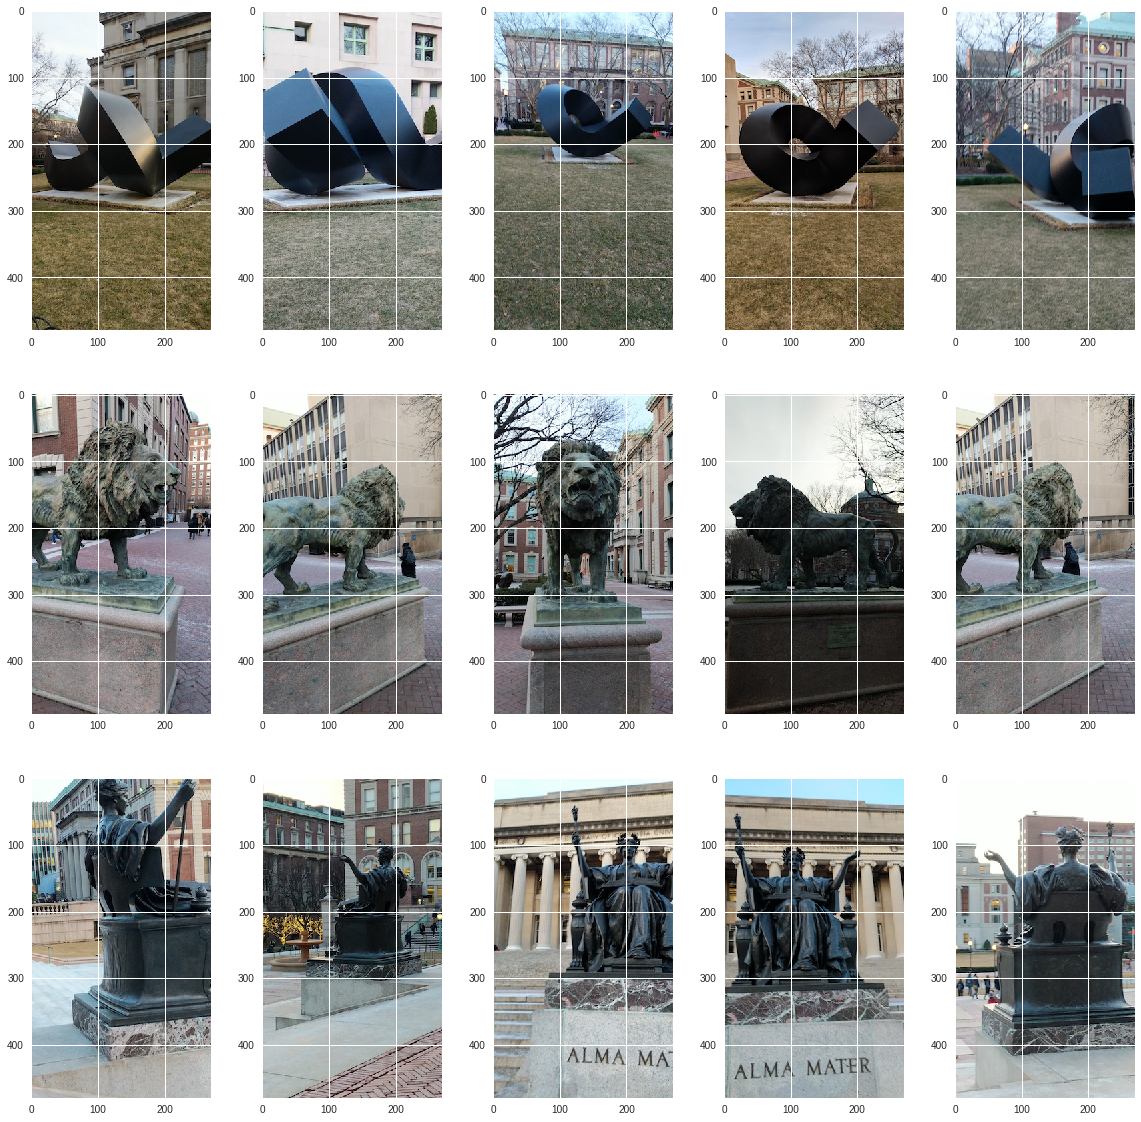

In [0]:
f, axarr = plt.subplots(3,5,figsize=(20,20))
sample_size = 5

sample_curl = rnd.sample(curl_list, sample_size)
sample_lion = rnd.sample(lion_list, sample_size)
sample_alma = rnd.sample(alma_list, sample_size)

for i in range(len(sample_curl)):
  img = mpimg.imread(os.path.join(curl_dir,sample_curl[i]))
  #axarr[i].imshow(os.path.join(curl_dir,sample_curl[i]))
  axarr[0,i].imshow(img)

for i in range(len(sample_lion)):
  img = mpimg.imread(os.path.join(lion_dir,sample_lion[i]))
  #axarr[i].imshow(os.path.join(curl_dir,sample_curl[i]))
  axarr[1,i].imshow(img)
 
for i in range(len(sample_alma)):
  img = mpimg.imread(os.path.join(alma_dir,sample_alma[i]))
  #axarr[i].imshow(os.path.join(curl_dir,sample_curl[i]))
  axarr[2,i].imshow(img)
#img=mpimg.imread(os.path.join(curl_dir,'00011XTR_00011_BURST20190228173530.jpg'))
#imgplot = plt.imshow(img)
f.show()

#### Create directory structure

In [0]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if not os.path.exists(train_dir):
    os.makedirs(train_dir)
    
if not os.path.exists(validation_dir):
    os.makedirs(validation_dir)
    
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

train_curl_dir = os.path.join(train_dir, 'curl')
train_lion_dir = os.path.join(train_dir, 'lion')
train_alma_dir = os.path.join(train_dir, 'alma_mater')

if not os.path.exists(train_curl_dir):
    os.makedirs(train_curl_dir)
    
if not os.path.exists(train_lion_dir):
    os.makedirs(train_lion_dir)
    
if not os.path.exists(train_alma_dir):
    os.makedirs(train_alma_dir)
    
val_curl_dir = os.path.join(validation_dir, 'curl')
val_lion_dir = os.path.join(validation_dir, 'lion')
val_alma_dir = os.path.join(validation_dir, 'alma_mater')

if not os.path.exists(val_curl_dir):
    os.makedirs(val_curl_dir)

if not os.path.exists(val_lion_dir):
    os.makedirs(val_lion_dir)
    
if not os.path.exists(val_alma_dir):
    os.makedirs(val_alma_dir)
    
test_curl_dir = os.path.join(test_dir, 'curl')
test_lion_dir = os.path.join(test_dir, 'lion')
test_alma_dir = os.path.join(test_dir, 'alma_mater')

if not os.path.exists(test_curl_dir):
    os.makedirs(test_curl_dir)
    
if not os.path.exists(test_lion_dir):
    os.makedirs(test_lion_dir)
    
if not os.path.exists(test_alma_dir):
    os.makedirs(test_alma_dir)
    

    


In [0]:
#num_cats_tr = len(os.listdir(train_cats_dir))
#num_dogs_tr = len(os.listdir(train_dogs_dir))
n_curl_tr = len (os.listdir(train_curl_dir))
n_lion_tr = len(os.listdir(train_lion_dir))
n_alma_tr = len(os.listdir(train_alma_dir))
#num_cats_val = len(os.listdir(validation_cats_dir))
#num_dogs_val = len(os.listdir(validation_dogs_dir))
n_curl_val = len(os.listdir(val_curl_dir))
n_lion_val = len(os.listdir(val_lion_dir))
n_alma_val = len(os.listdir(val_alma_dir))

total_train = n_lion_tr + n_curl_tr + n_alma_tr
total_val = n_lion_val+ n_curl_val + n_alma_val

#### Create file lists to generate train/validation/test splits
* Credit to https://cs230-stanford.github.io/train-dev-test-split.html for the assistance on doing this efficiently

In [0]:
curl_list.sort()
random.seed(42)
#Note: maintain balanced dataset by selecting same # of images as min amongst all classes
curl_list = random.sample(curl_list, 315)

random.shuffle(curl_list) # shuffles the ordering of filenames (deterministic given the chosen seed)

split_1 = int(100./175. * len(curl_list))
split_2 = int(150./175. * len(curl_list))
train_curl = curl_list[:split_1]
val_curl = curl_list[split_1:split_2]
test_curl = curl_list[split_2:]
print(len(train_curl),len(val_curl),len(test_curl))


180 90 45


In [0]:
for _ in curl_list:
  #print(_)
  #print('curl_dir:', curl_dir)
  current = os.path.join(curl_dir, _)
  #print('current:', current)
  
  if _ in train_curl:
    #print('in train_curl')
    new = os.path.join(train_curl_dir, _)
    #print('new:', new)
    if not os.path.exists(new):
      #print('file not already written')
      os.rename(current, new)
      
  elif _ in val_curl:
    new = os.path.join(val_curl_dir, _)
    if not os.path.exists(new):
      os.rename(current, new)
  else:
    new = os.path.join(test_curl_dir, _)
    if not os.path.exists(new):
      os.rename(current, new)

tmp/landmarks/landmarks/the_curl

 check if files distributed to correct folders properly: 

In [0]:
print(len(os.listdir(train_curl_dir)), len(os.listdir(val_curl_dir)), len(os.listdir(test_curl_dir)))

180 90 45


* It works!

In [0]:
lion_list.sort()  # make sure that the filenames have a fixed order before shuffling
random.seed(42)
#Note: maintain balanced dataset by selecting same # of images as min amongst all classes
lion_list = random.sample(lion_list, 315)

random.shuffle(lion_list) # shuffles the ordering of filenames (deterministic given the chosen seed)

split_1 = int(100./175. * len(lion_list))
split_2 = int(150./175. * len(lion_list))
train_lion = lion_list[:split_1]
val_lion = lion_list[split_1:split_2]
test_lion = lion_list[split_2:]
print(len(train_lion),len(val_lion),len(test_lion))


180 90 45


In [0]:
alma_list.sort()  # make sure that the filenames have a fixed order before shuffling
random.seed(42)
#Note: maintain balanced dataset by selecting same # of images as min amongst all classes
alma_list = random.sample(alma_list, 315)

random.shuffle(alma_list) # shuffles the ordering of filenames (deterministic given the chosen seed)

split_1 = int(100./175. * len(alma_list))
split_2 = int(150./175. * len(alma_list))
train_alma = alma_list[:split_1]
val_alma = alma_list[split_1:split_2]
test_alma = alma_list[split_2:]
print(len(train_alma),len(val_alma),len(test_alma))

180 90 45


In [0]:
for _ in lion_list:
  current = os.path.join(lion_dir, _)
  if _ in train_lion:
    new = os.path.join(train_lion_dir, _)
    if not os.path.exists(new):
      os.rename(current, new)
  elif _ in val_lion:
    new = os.path.join(val_lion_dir, _)
    if not os.path.exists(new):
      os.rename(current, new)
  else:
    new = os.path.join(test_lion_dir, _)
    if not os.path.exists(new):
      os.rename(current, new)

In [0]:
print(len(os.listdir(train_lion_dir)), len(os.listdir(val_lion_dir)), len(os.listdir(test_lion_dir)))

180 90 45


In [0]:
for _ in alma_list:
  current = os.path.join(alma_dir, _)
  if _ in train_alma:
    new = os.path.join(train_alma_dir, _)
    if not os.path.exists(new):
      os.rename(current, new)
  elif _ in val_alma:
    new = os.path.join(val_alma_dir, _)
    if not os.path.exists(new):
      os.rename(current, new)
  else:
    new = os.path.join(test_alma_dir, _)
    if not os.path.exists(new):
      os.rename(current, new)

In [0]:
print(len(os.listdir(train_alma_dir)), len(os.listdir(val_alma_dir)), len(os.listdir(test_alma_dir)))

180 90 45


In [0]:
len(os.listdir(train_curl_dir)), len(os.listdir(train_lion_dir)), len(os.listdir(train_alma_dir))

(180, 180, 180)

#### Model data is now well balanced across all classes
* Also has been split into training, validation, and test sets on same proportion as specified in assignment. this 100/50/25 split comes out to 180/90/45 when working with 315 images. 

## Part 2 - Q2 - Classify landmarks data set using transfer learning
* We follow the same basic approach as seen in Part 1 Q2

### Instantiating the model: Xception
* I chose to use the Xception model- the authors claim it outperforms Inception V3, and is hence useful for transfer learning in computer vision applications. 
* It's worth noting that Xception has nearly 21 million paramaters, to VGG16's paltry 14.7. Perhaps this will be a foolish choice for training purposes, but I am bold. 
* Notice we do not include the `top` nAKA the Dense layers used to classify the 1,000 classes from ImageNet.

In [0]:
conv_base_Xc = Xception(include_top=False, weights='imagenet', input_shape=(150,150, 3))


83689472/83683744 [==============================] - 2s 0us/step


In [0]:
conv_base_Xc.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

#### Pre-processing with ImageDataGenerator
* Choose batch size of 15 to accommodate integer-valued train/validation sample size
* Match feature dimensions to final layer of Xception
* Match label space to class dim of 3

* **Note that we downsample to 450/225 because the image generator does not recognize all images in the training and validation sets**
> * see output in cell below - expected 540 training images, identified 538, and 270/269 for validation

Final Note: the model uses 21m parameters.. do we really need this large of a model for this task? 


In [0]:
TARGET_SHAPE = 150 

#batch size altered to be factor of sample size
BATCH_SIZE = 15


In [0]:
import PIL
from PIL import Image

In [0]:
# Cache activations for our training and validation data
datagen = ImageDataGenerator(rescale=1./255)

def extract_features(directory, sample_count):
  
  #note, this line was modified to fit dense layer in Xception
    features = np.zeros(shape=(sample_count, 5, 5, 2048))
    labels = np.zeros(shape=(sample_count,3))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(TARGET_SHAPE, TARGET_SHAPE),
        batch_size=BATCH_SIZE,
        #changed for problem at hand
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
      
        features_batch = conv_base_Xc.predict(inputs_batch)
        # print(features_batch.shape)
        # (32, 4, 4, 512)
        # Think: batch_size, rows, cols, channels
        
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features_Xc, train_labels_Xc = extract_features(train_dir, 450)
validation_features_Xc, validation_labels_Xc = extract_features(validation_dir, 225)

Found 538 images belonging to 3 classes.
Found 269 images belonging to 3 classes.


In [0]:
test_features_Xc, test_labels_Xc = extract_features(test_dir, 120)

Found 135 images belonging to 3 classes.


#### The features are now shape (15, 5, 5, 2048), which match Xception's dense layer and the batch size prepared

In [0]:
train_features_Xc.shape

(450, 5, 5, 2048)

In [0]:
FLATTENED_SHAPE = 5 * 5 * 2048

train_features_Xc = np.reshape(train_features_Xc, (450, FLATTENED_SHAPE))
validation_features_Xc = np.reshape(validation_features_Xc, (225, FLATTENED_SHAPE))
test_features_Xc = np.reshape(test_features_Xc, (120, FLATTENED_SHAPE))

Now, we can define a simple model, and train it using the features we just extracted from VGG16. This model should train quickly (we're only learning weights for the Dense layers).

In [0]:
EPOCHS = 10

### Xception caching run
* Hyperparameter notes:
> * reduced dropout to 0.2
> * output layer uses softmax with dim = 3
> * loss function = categorical crossentropy for multi-class classification

In [0]:
model_Xc = Sequential()
model_Xc.add(Dense(256, activation='relu', input_dim=FLATTENED_SHAPE))
model_Xc.add(Dropout(0.2))
#output layer dim = 5
model_Xc.add(Dense(3, activation='softmax'))
#softmax used instead of sigmoid for multiclass, single-label classification, per ch 4.1 pp 114

model_Xc.compile(optimizer='adam',
              #altered for multi-class
              loss='categorical_crossentropy',
              metrics=['acc'])

history_Xception = model_Xc.fit(train_features_Xc, train_labels_Xc,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(validation_features_Xc, validation_labels_Xc))

Train on 450 samples, validate on 225 samples
Epoch 1/10
450/450 [==============================] - 2s 3ms/sample - loss: 5.1310 - acc: 0.6644 - val_loss: 5.3033 - val_acc: 0.6711
Epoch 2/10
450/450 [==============================] - 1s 2ms/sample - loss: 5.2294 - acc: 0.6756 - val_loss: 5.3028 - val_acc: 0.6711
Epoch 3/10
450/450 [==============================] - 1s 2ms/sample - loss: 5.3339 - acc: 0.6644 - val_loss: 5.2381 - val_acc: 0.6711
Epoch 4/10
450/450 [==============================] - 1s 2ms/sample - loss: 5.1961 - acc: 0.6756 - val_loss: 4.5042 - val_acc: 0.7111
Epoch 5/10
450/450 [==============================] - 1s 2ms/sample - loss: 5.2046 - acc: 0.6711 - val_loss: 5.2299 - val_acc: 0.6756
Epoch 6/10
450/450 [==============================] - 1s 2ms/sample - loss: 4.0518 - acc: 0.7422 - val_loss: 3.7918 - val_acc: 0.7556
Epoch 7/10
450/450 [==============================] - 1s 2ms/sample - loss: 1.8093 - acc: 0.8822 - val_loss: 0.9324 - val_acc: 0.9378
Epoch 8/10
450/4

#### Accuracy, Loss plots for Xception, cache trick


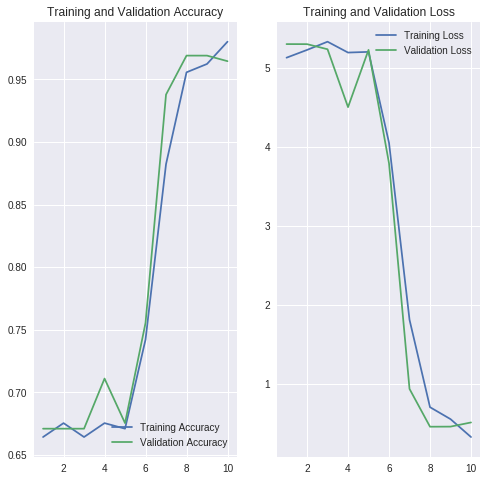

In [0]:
acc = history_Xception.history['acc']
val_acc = history_Xception.history['val_acc']

loss = history_Xception.history['loss']
val_loss = history_Xception.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Average of final two accuracies for Xception w/caching trick

In [0]:
print(np.mean(history_Xception.history['val_acc'][-2:]))

0.9666667


In [0]:
test_features_Xc.shape, test_labels_Xc.shape

((120, 51200), (120, 3))

In [0]:
test_score = model_Xc.evaluate(x=test_features_Xc, y =test_labels_Xc, batch_size=15)

120/120 [==============================] - 0s 511us/sample - loss: 0.4030 - acc: 0.9750


* Test accuracy actually outperforms validation, at 97.5%

### Xception data augmentation with frozen base

* Output layer dim = 3, softmax, using a 256 neuron dense layer with relu activation

In [0]:
model_Xc2 = Sequential()
model_Xc2.add(conv_base_Xc)
model_Xc2.add(Flatten())
model_Xc2.add(Dense(256, activation='relu'))
model_Xc2.add(Dense(3, activation='softmax'))

Here's how our model looks now.

In [0]:
model_Xc2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_4 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 771       
Total params: 33,969,707
Trainable params: 33,915,179
Non-trainable params: 54,528
_________________________________________________________________


In [0]:
conv_base_Xc.trainable = False

In [0]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=train_dir, 
    shuffle=True, 
    target_size=(TARGET_SHAPE,TARGET_SHAPE),
    class_mode='categorical')

# Validation data should not be augmented!
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=validation_dir, 
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode='categorical')

Found 538 images belonging to 3 classes.
Found 269 images belonging to 3 classes.


In [0]:
test_data_gen = image_gen_val.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=test_dir, 
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode='categorical', shuffle=False, seed = 42)

Found 135 images belonging to 3 classes.


In [0]:
EPOCHS_da = 10

Training model

In [0]:
model_Xc2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

# Now is a good time for a cup of coffee
history_Xc2 = model_Xc2.fit_generator(
      train_data_gen,
      steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
      epochs=EPOCHS_da,
      validation_data=val_data_gen,
      validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
      verbose=2)

Epoch 1/10
18/18 [==============================] - 3s 174ms/step - loss: 8.2876 - acc: 0.4758
 - 9s - loss: 9.2739 - acc: 0.3848 - val_loss: 8.2876 - val_acc: 0.4758
Epoch 2/10
18/18 [==============================] - 2s 119ms/step - loss: 8.0436 - acc: 0.4833
 - 7s - loss: 7.5693 - acc: 0.5149 - val_loss: 8.0436 - val_acc: 0.4833
Epoch 3/10
18/18 [==============================] - 2s 119ms/step - loss: 7.7000 - acc: 0.5093
 - 7s - loss: 7.2509 - acc: 0.5409 - val_loss: 7.7000 - val_acc: 0.5093
Epoch 4/10
18/18 [==============================] - 2s 127ms/step - loss: 7.0779 - acc: 0.5576
 - 8s - loss: 6.4209 - acc: 0.5948 - val_loss: 7.0779 - val_acc: 0.5576
Epoch 5/10
18/18 [==============================] - 2s 126ms/step - loss: 10.7241 - acc: 0.3346
 - 8s - loss: 9.0518 - acc: 0.4312 - val_loss: 10.7241 - val_acc: 0.3346
Epoch 6/10
18/18 [==============================] - 2s 128ms/step - loss: 7.0816 - acc: 0.5539
 - 8s - loss: 8.2341 - acc: 0.4796 - val_loss: 7.0816 - val_acc: 0.5

#### Xception: Results for data augmentation and training with frozen base

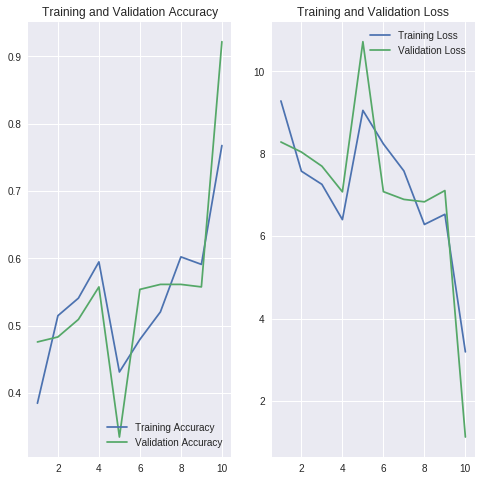

In [0]:
acc = history_Xc2.history['acc']
val_acc = history_Xc2.history['val_acc']

loss = history_Xc2.history['loss']
val_loss = history_Xc2.history['val_loss']

epochs_range = range(1, EPOCHS_da+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Perhaps we haven't trained for long enough.. odd behavior at beginning of run. I tried again with 20 epochs, resetting the runtime prior:

In [0]:
EPOCHS_da2 = 20

In [0]:
model_Xc2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

# Now is a good time for a cup of coffee
history_Xc2 = model_Xc2.fit_generator(
      train_data_gen,
      steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
      epochs=EPOCHS_da2,
      validation_data=val_data_gen,
      validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
      verbose=2)

Epoch 1/20
18/18 [==============================] - 4s 225ms/step - loss: 6.1062 - acc: 0.6059
 - 11s - loss: 6.7044 - acc: 0.5260 - val_loss: 6.1062 - val_acc: 0.6059
Epoch 2/20
18/18 [==============================] - 2s 120ms/step - loss: 3.0378 - acc: 0.7621
 - 7s - loss: 5.9590 - acc: 0.5967 - val_loss: 3.0378 - val_acc: 0.7621
Epoch 3/20
18/18 [==============================] - 2s 121ms/step - loss: 0.7258 - acc: 0.9331
 - 8s - loss: 1.9115 - acc: 0.8420 - val_loss: 0.7258 - val_acc: 0.9331
Epoch 4/20
18/18 [==============================] - 2s 117ms/step - loss: 0.4958 - acc: 0.9591
 - 8s - loss: 0.7155 - acc: 0.9349 - val_loss: 0.4958 - val_acc: 0.9591
Epoch 5/20
18/18 [==============================] - 2s 121ms/step - loss: 0.6640 - acc: 0.9368
 - 8s - loss: 0.6245 - acc: 0.9405 - val_loss: 0.6640 - val_acc: 0.9368
Epoch 6/20
18/18 [==============================] - 2s 120ms/step - loss: 0.5642 - acc: 0.9554
 - 8s - loss: 0.4889 - acc: 0.9480 - val_loss: 0.5642 - val_acc: 0.95

#### Xception: Results for data augmentation and training with frozen base

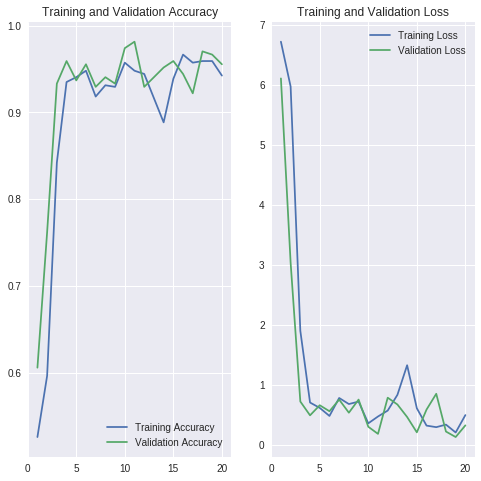

In [0]:
acc = history_Xc2.history['acc']
val_acc = history_Xc2.history['val_acc']

loss = history_Xc2.history['loss']
val_loss = history_Xc2.history['val_loss']

epochs_range = range(1, EPOCHS_da2+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
print(np.mean(history_Xc2.history['val_acc'][5:-5]))

0.94944227


In [0]:
test_features_Xc2, test_labels_Xc2 = extract_features(test_dir, 120)

Found 135 images belonging to 3 classes.


In [0]:
test_score = model_Xc2.evaluate(x=test_data_gen, batch_size=15)

9/9 [==============================] - 1s 112ms/step - loss: 0.0533 - acc: 0.9926


* 99.26% accuracy on test set! 

### Notes
1. It doesn't suprise me that train and validation performance is very similar, and that we do not notice the typical downgrade in performance
* This is due to the fact that all of the pictures were taken in relatively similar conditions, by the same person
> * One wonders if we've actually just created a classifier to be able to tell the difference between *pictures taken by me* of three different landmarks. This may seem like semantics, but it's truly important when it comes to a discussion of bias in our results as data scientists. 
* Also compounded by the distinct nature of the subject matter we have chosen to classify
> * two out of three of the sculptures were made of bronze
> * dissimilar scale for the odd one out, likely very few false positives for 'the curl'
>* they each had significantly different shapes

2. A nearly 2% (absolute) improvement in accuracy was observed on the test set between caching and data augmentation methods
* This could be evidence that data augmentation is a smart choice for improving real-world performance


## Part 2 - Q3 - How small of a model can we train (parameter-wise) while still obtaining decent performance? *Enter MobileNetV2*
* TL;DR: trying MobileNetV2 to compare given it's VGG16-like performance on ImageNet with ~15% the parameters as Xception. 

* A quick study of the documentation on the keras applications module provides some information that is valuable here:
> * Up front, VGG16 and Xception are good models to compare. As shown in Part 1, each achieves good performance for multi-class problems, VGG taking only a slight hit in performance on the mini-flowers task with significantly less parameters. 
> * An interesting note is that while, in this notebook, we see ~14m parameters for VGG16, the keras documentation suggests this model has ~138m parameters. This could feasibly be due to the elimination of the dense layers as trained on ImageNet, which had far more classes than our task at hand

* GIven that we have already demonstrated similar performance on VGG16 vs Xception, I am now choosing to evaluate performance of the landmarks task on Xception against **MobileNetV2**. 
> * MobileNetV2 achieved similar performance as VGG16 on the ImageNet dataset, with only 3.5m parameters (fully model).
> * Let's see how MobileNetV2 performs on this task!


In [0]:
from tensorflow.keras.applications import MobileNetV2


In [0]:
#conv_base_Xc = Xception(include_top=False, weights='imagenet', input_shape=(150,150, 3))
conv_base_MNV2 = MobileNetV2(alpha=1.0, include_top=False, weights='imagenet', input_tensor=None, pooling=None, input_shape=(160,160,3))


Instructions for updating:
Colocations handled automatically by placer.


* Default settings for alpha & depth multiplier for "stock"-ish comparison based on ImageNet training.
* Note: had to change input shape to 160x160, to accommodate pre-trained options for input shape. This was closest option to choice in prior modeling approaches using Xception & VGG16
* Pooling? Might be a good option to reduce parameter space further


In [0]:
conv_base_MNV2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

Notes:
* 2.25m parameters.. significantly less than Xception or VGG16
* Depth of output layer is in between that of Xception (2048) or VGG16 (512)

#### MobileNetV2: Pre-processing with ImageDataGenerator
* Choose batch size of 15 to accommodate integer-valued train/validation sample size
* Adjusted TARGET_SHAPE to match input shape requirements of MobileNetV2
* Match feature dimensions to final layer of MobileNetV2
* Match label space to class dim of 3

* **Note that we downsample to 450/225 because the image generator does not recognize all images in the training and validation sets**
> * see output in cell below - expected 540 training images, identified 538, and 270/269 for validation


In [0]:
TARGET_SHAPE = 160

#batch size altered to be factor of sample size
BATCH_SIZE = 15


In [0]:
import PIL
from PIL import Image

In [0]:
# Cache activations for our training and validation data
datagen = ImageDataGenerator(rescale=1./255)

def extract_features(directory, sample_count):
  
  #note, this line was modified to fit dense layer in Xception
    features = np.zeros(shape=(sample_count, 5, 5, 1280))
    labels = np.zeros(shape=(sample_count,3))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(TARGET_SHAPE, TARGET_SHAPE),
        batch_size=BATCH_SIZE,
        #changed for problem at hand
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
      
        features_batch = conv_base_MNV2.predict(inputs_batch)
        # print(features_batch.shape)
        # (32, 4, 4, 512)
        # Think: batch_size, rows, cols, channels
        
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features_MNV2, train_labels_MNV2 = extract_features(train_dir, 450)
validation_features_MNV2, validation_labels_MNV2 = extract_features(validation_dir, 225)

Found 538 images belonging to 3 classes.
Found 269 images belonging to 3 classes.


In [0]:
test_features_MNV2, test_labels_MNV2 = extract_features(test_dir, 120)

Found 135 images belonging to 3 classes.


#### The features are now shape (15, 5, 5, 1280), which match Xception's dense layer

In [0]:
test_features_MNV2.shape

(120, 5, 5, 1280)

In [0]:
FLATTENED_SHAPE = 5 * 5 * 1280

train_features_MNV2 = np.reshape(train_features_MNV2, (450, FLATTENED_SHAPE))
validation_features_MNV2 = np.reshape(validation_features_MNV2, (225, FLATTENED_SHAPE))
test_features_MNV2 = np.reshape(test_features_MNV2, (120, FLATTENED_SHAPE))

Now, we can define a simple model, and train it using the features we just extracted from VGG16. This model should train quickly (we're only learning weights for the Dense layers).

In [0]:
EPOCHS = 10

### MobileNetV2 caching run
* Hyperparameter notes: maintained the same hyperparameters as in Xception run
> * Dropout = 0.2
> * output layer uses softmax with dim = 3
> * loss function = categorical crossentropy for multi-class classification

In [0]:
model_MNV2 = Sequential()
model_MNV2.add(Dense(256, activation='relu', input_dim=FLATTENED_SHAPE))
model_MNV2.add(Dropout(0.5))
#output layer dim = 5
model_MNV2.add(Dense(3, activation='softmax'))
#softmax used instead of sigmoid for multiclass, single-label classification, per ch 4.1 pp 114

model_MNV2.compile(optimizer='adam',
              #altered for multi-class
              loss='categorical_crossentropy',
              metrics=['acc'])

history_MNV2 = model_MNV2.fit(train_features_MNV2, train_labels_MNV2,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(validation_features_MNV2, validation_labels_MNV2))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 450 samples, validate on 225 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
450/450 [==============================] - 1s 2ms/sample - loss: 0.6938 - acc: 0.9267 - val_loss: 0.1433 - val_acc: 0.9911
Epoch 2/10
450/450 [==============================] - 0s 1ms/sample - loss: 0.0667 - acc: 0.9911 - val_loss: 5.7140e-05 - val_acc: 1.0000
Epoch 3/10
450/450 [==============================] - 0s 1ms/sample - loss: 0.0716 - acc: 0.9956 - val_loss: 0.0716 - val_acc: 0.9956
Epoch 4/10
450/450 [==============================] - 0s 1ms/sample - loss: 0.0815 - acc: 0.9933 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 5/10
450/450 [==============================] - 0s 1ms/sample - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1008e-06 - val_acc: 1.0000
Epoch 6/10
450/450 [==============================] - 0s 1ms/sample - loss: 1.1812e-06 - acc: 1.0000 - va

#### Accuracy, Loss plots for Xception, cache trick


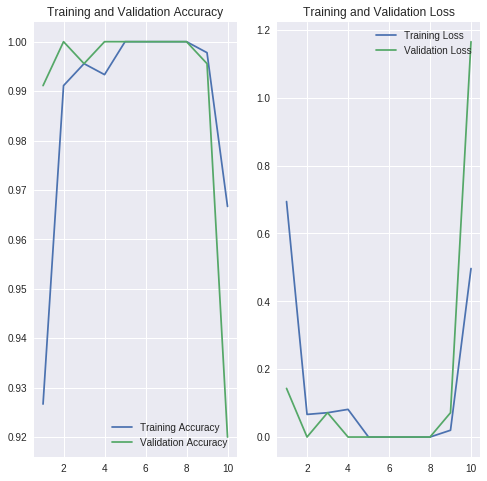

In [0]:
acc = history_MNV2.history['acc']
val_acc = history_MNV2.history['val_acc']

loss = history_MNV2.history['loss']
val_loss = history_MNV2.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Average of final 10 validation accuracies for Xception w/caching trick

In [0]:
print(np.mean(history_MNV2.history['val_acc'][-5:]))

0.9831111


In [0]:
test_score_MNV2 = model_MNV2.evaluate(x=test_features_MNV2, y=test_labels_MNV2, batch_size=15)

120/120 [==============================] - 0s 397us/sample - loss: 1.2163 - acc: 0.9083


* Note: impressive validation performance achieved with "small" model MobileNetV2 vs Xception & VGG16.
* Ultimately, this does not seem to be a difficult or taxing classificaiton task for any of these algorithms
* *However*, it's worth noting that the test performance is significantly lower (see above - 91%), perhaps suggesting that the smaller model utilized here is less transferable to "unseen" images

### MobileNetV2 data augmentation with frozen base
* Given performance of caching approach using MobileNetV2, let's try further reducing the number of neurons in the dense layer and seeing the impact of performance
> * This is worth doing, as we can observe that 75% of the parameters of this model exist in the dense layer if using a dense layer of 256 neurons -- 8.2m parameters in hidden dense layer

* Output layer dim = 3, softmax, using a 128 neuron dense layer with relu activation

In [0]:
model_MNV2_2 = Sequential()
model_MNV2_2.add(conv_base_MNV2)
model_MNV2_2.add(Flatten())
model_MNV2_2.add(Dense(128, activation='relu'))
model_MNV2_2.add(Dense(3, activation='softmax'))

Here's how our model looks now.

In [0]:
model_MNV2_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               4096128   
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 387       
Total params: 6,354,499
Trainable params: 6,320,387
Non-trainable params: 34,112
_________________________________________________________________


Before we train our model, we need to "freeze" the convolutional base (this prevents it from being updated during training).  Since the Dense layers we've added have their weights initialized randomly, they will make large errors initially, and the gradient in turn would be propagated backward through VGG (causing erroneously large updates to already useful weights)

In [0]:
conv_base_MNV2.trainable = False

In [0]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=train_dir, 
    shuffle=True, 
    target_size=(TARGET_SHAPE,TARGET_SHAPE),
    class_mode='categorical')

# Validation data should not be augmented!
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=validation_dir, 
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode='categorical')

Found 538 images belonging to 3 classes.
Found 269 images belonging to 3 classes.


In [0]:
test_data_gen = image_gen_val.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=test_dir, 
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode='categorical', shuffle=False, seed=42)

Found 135 images belonging to 3 classes.


In [0]:
EPOCHS_da = 10

Let's compile and train our model. This will be quite slow. Now would be a good time to get a cup of coffee.

In [0]:
model_MNV2_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

# Now is a good time for a cup of coffee
history_MNV2_2 = model_MNV2_2.fit_generator(
      train_data_gen,
      steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
      epochs=EPOCHS_da,
      validation_data=val_data_gen,
      validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
      verbose=2)

Epoch 1/10
18/18 [==============================] - 3s 151ms/step - loss: 0.4266 - acc: 0.9703
 - 9s - loss: 2.0246 - acc: 0.8178 - val_loss: 0.4266 - val_acc: 0.9703
Epoch 2/10
18/18 [==============================] - 2s 109ms/step - loss: 1.9808 - acc: 0.8290
 - 7s - loss: 0.3718 - acc: 0.9684 - val_loss: 1.9808 - val_acc: 0.8290
Epoch 3/10
18/18 [==============================] - 2s 109ms/step - loss: 1.8755 - acc: 0.8550
 - 7s - loss: 0.6846 - acc: 0.9405 - val_loss: 1.8755 - val_acc: 0.8550
Epoch 4/10
18/18 [==============================] - 2s 107ms/step - loss: 0.6919 - acc: 0.9405
 - 7s - loss: 0.2640 - acc: 0.9758 - val_loss: 0.6919 - val_acc: 0.9405
Epoch 5/10
18/18 [==============================] - 2s 111ms/step - loss: 0.1510 - acc: 0.9851
 - 7s - loss: 0.4319 - acc: 0.9647 - val_loss: 0.1510 - val_acc: 0.9851
Epoch 6/10
18/18 [==============================] - 2s 108ms/step - loss: 3.7220e-04 - acc: 1.0000
 - 7s - loss: 0.3832 - acc: 0.9665 - val_loss: 3.7220e-04 - val_ac

#### MobileNet V2: Results for data augmentation and training with frozen base
* Note, results obtained with reduced dense layer parameters
* Total of ~6m parameters for competitive accuracy

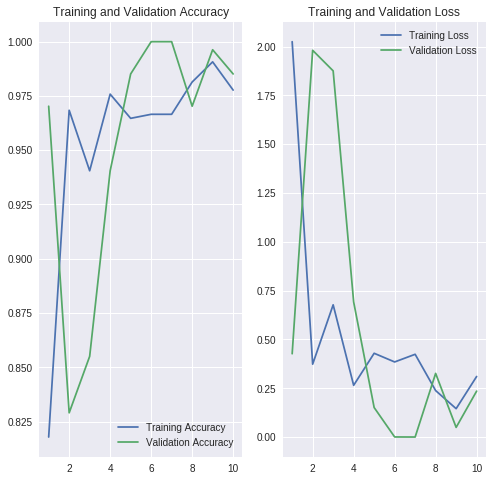

In [0]:
acc = history_MNV2_2.history['acc']
val_acc = history_MNV2_2.history['val_acc']

loss = history_MNV2_2.history['loss']
val_loss = history_MNV2_2.history['val_loss']

epochs_range = range(1, EPOCHS_da+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### MobileNetV2: Results for data augmentation and training with frozen base

In [0]:
print(np.mean(history_MNV2_2.history['val_acc'][-5:]))

0.99033463


In [0]:
test_features_MNV2_2, test_labels_MNV2_2 = extract_features(test_dir, 120)

Found 135 images belonging to 3 classes.


In [0]:
test_score = model_MNV2_2.evaluate(x=test_data_gen, batch_size=15)

9/9 [==============================] - 1s 73ms/step - loss: 0.1194 - acc: 0.9926


### Notes

1.We are able to achieve excellent performance within ten epochs on the pre-trained base using a dense layer with 128 neurons.
> * 99.0% validation, 99.3% test accuracy
>>
---- 
2. This results in a model that provides equivalent accuracy as compared to Xception & VGG16, with far fewer parameters:
> * Xception: ~34M trainable parameters
> * MobileNet V2: ~6M trainable parameters

* Note that this equivalent performance was achieved with a smaller dense layer on MobileNet V2, further reducing total parameters in that model

* In general, we should also note that the caching method appears to outperform the data augmentation + frozen base approach and is *also faster*